# Seattle Airbnb data exploration

In this jupyter notebook 3 csv files of different Seattle Airbnb data will be imported to answer 3 business quesitions.  Prior to answering the questions, the data will be imported, studied, and prepared so that proper analysis can be conducted.

The three questions are:
- What is the average review score by neighborhood?
- Which features are the most important when it comes to determining which Airbnbs are more popular? (i.e. have the most stays, specifically the highest revews_per_month)
- What months are the year are most popular for visiting Seattle?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

In [2]:
lst = pd.read_csv("listings.csv")
cal = pd.read_csv("calendar.csv")
rev = pd.read_csv("reviews.csv")

# replace the missing values with np.nan to ensure they are coded correctly.
lst.fillna(np.nan, inplace=True)
cal.fillna(np.nan, inplace=True)
rev.fillna(np.nan, inplace=True)

## Explore the Data

As this is an unfamiliar dataset, it would be useful to understand some basic information such as the following:
- display the head info for each dataframe
- number of rows and columns
- which features have only one value (these could be dropped)
- which features are categorical vs numeric
- basic statistics about the numeric features
- unique values of the categorical features
- info relating to the missing data including how many features have missing data, proportion of missing by feature

Since there are 3 datasets a 'describe_data' function will be used to view info related to the above list

In [3]:
def describe_data(df, csv_name):
    '''
    Inputs:
    df - Pandas Dataframe
    csv_name - string value representing name of the dataframe
    
    Take a dataframe as input and plot some general info such as basic shape, datatypes, basic statistics, and info regarding missing values.   
    
    returns some lists of column names for columns that can be dropped, numeric columns, and non-numeric columns
    '''
    
    #helper code
    dash = '-' * 70
    newline = '\n' * 3
    df_len = len(df)
    
    # head info
    print(f'{dash}Head Information for {csv_name}{dash}')
    display(df.head())
    
    # basic shape and stats
    print(newline)
    print(f'{dash}Basic Shape Information for {csv_name}{dash}')
    print(f'{csv_name} contains {df.shape[0]:,} rows and {df.shape[1]:,} columns.')
    
    # find columns with just one value, these can be dropped
    drop_columns = []
    for col in df:
        if len(df[col].unique()) == 1:
            drop_columns.append(col)
    
    print(newline)
    print(f'The following columns only contain one value and can be dropped: {", ".join(drop_columns)}')
    
    # list the numeric columns
    numeric_cols = df.select_dtypes(include='number').columns
    print(newline)
    print(f'These columns are numeric: {", ".join(numeric_cols)}')
    
    # print descriptive statistics for dataframe
    print(newline)
    print(f'{dash}Basic statistics for {csv_name}{dash}')
    with pd.option_context('display.max_columns', None):
        display(df.describe())
        
    print(newline)
    print(f'{dash}Histograme of numeric features {csv_name}{dash}')
    df.hist(figsize=(20,10));
    plt.tight_layout()
    plt.show(plt.gcf())
    
    
    # print numeric info
    print(newline)
   # print(f'{dash}First 5 top values with counts for each non-numeric feature {csv_name}{dash}')
    for col in df[numeric_cols]:
        num_na = df[col].isna().sum()
        num_filled = df_len - num_na
        proportion_na = num_na / df_len        
        col_mean = df[col].mean()
        col_median = df[col].median()
        print(f'{df[col].name}|| mean: {col_mean:,.0f}   median: {col_median:,.0f}   Not_NA: {num_filled:,.0f}   NA: {num_na:,.0f} proportion_NA: {proportion_na:.1%}\n')
    
    # get general info on non-numeric features
    non_numeric_cols = df.select_dtypes(exclude='number').columns
    print(newline)
    print(f'These columns are non-numeric dtypes: {", ".join(non_numeric_cols)}')
    
    print(newline)
    print(f'{dash}First 5 top values with counts for each non-numeric feature {csv_name}{dash}')
    for col in df[non_numeric_cols]:
        # get count info about column
        num_unique = len(df[col].unique())
        num_na = df[col].isna().sum()
        num_filled = df_len - num_na
        proportion_na = num_na / df_len        
        
        # get info about top values
        names = list(df[col].value_counts()[0:5].index)
        sliced_names = [str(name)[:25] for name in names]
        values = list(df[col].value_counts()[0:5])
        print(f'{df[col].name}: {list(zip(sliced_names,values))}')
        print(f'num_unique: {num_unique:,.0f}   not_NA: {num_filled:,.0f}   NA: {num_na:,.0f}   proportion_NA: {proportion_na:.1%}\n')
               
    # More information about missing data
    print(newline)
    print(f'{dash}More information about missing data for {csv_name}{dash}')
    
    # visualize how many rows per column have null values.
    missing_data = df.isna().sum(axis=0)

    plt.figure(figsize=(7,20))
    sns.barplot(y=missing_data.index,
                x=missing_data.values,
                color='blue'
               );
    plt.xticks(rotation=45);
    plt.title('Count of Missing Values in Dataframe by column');
    plt.show(plt.gcf())
    
    #show column missing data as a histogram
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    sns.ecdfplot(missing_data, ax=axs[1]);
    sns.histplot(x=missing_data, ax=axs[0], stat='probability');
    axs[0].set_xlabel('Number of missing values per column')
    axs[0].set_ylabel('Proportion of column')
    axs[1].set_xlabel('Number of missing values per column')
    axs[1].set_ylabel('Proportion of columns')
    axs[1].set_yticks(list(np.arange(0.0,1.1,0.1)));
    plt.suptitle('Histogram & Cumulative distribution of number of missing values per column');
    plt.show(plt.gcf())
    
    # How much data is missing in each row of the dataset?
    missing_row = df.isna().sum(axis=1) 

    # plot a histogram cumulative distribution function to visualize the data
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    sns.ecdfplot(missing_row, ax=axs[1]);
    sns.histplot(x=missing_row, ax=axs[0], stat='probability');
    plt.xticks(rotation=45);
    axs[0].set_xlabel('Number of missing values per row')
    axs[0].set_ylabel('Proportion of rows')
    axs[1].set_xlabel('Number of missing values per row')
    axs[1].set_ylabel('Proportion of rows')
    axs[1].set_yticks(list(np.arange(0.0,1.1,0.1)));
    plt.suptitle('Histogram & Cumulative distribution of number of missing values per row');
    plt.show(plt.gcf())
    print(newline)
    
    return drop_columns, numeric_cols, non_numeric_cols

Now each data set can be explore

----------------------------------------------------------------------Head Information for listings.csv----------------------------------------------------------------------


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89






----------------------------------------------------------------------Basic Shape Information for listings.csv----------------------------------------------------------------------
listings.csv contains 3,818 rows and 92 columns.




The following columns only contain one value and can be dropped: scrape_id, last_scraped, experiences_offered, market, country_code, country, has_availability, calendar_last_scraped, requires_license, license, jurisdiction_names




These columns are numeric: id, scrape_id, host_id, host_listings_count, host_total_listings_count, latitude, longitude, accommodates, bathrooms, bedrooms, beds, square_feet, guests_included, minimum_nights, maximum_nights, availability_30, availability_60, availability_90, availability_365, number_of_reviews, review_scores_rating, review_scores_accuracy, review_scores_cleanliness, review_scores_checkin, review_scores_communication, review_scores_location, review_scores_value, license, calculated_host_listings_count, reviews

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,square_feet,guests_included,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,reviews_per_month
count,3.818000e+03,3.818000e+03,3.818000e+03,3816.000000,3816.000000,3818.000000,3818.000000,3818.000000,3802.000000,3812.000000,3817.000000,97.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3171.000000,3160.000000,3165.000000,3160.000000,3167.000000,3163.000000,3162.000000,0.0,3818.000000,3191.000000
mean,5.550111e+06,2.016010e+13,1.578556e+07,7.157757,7.157757,47.628961,-122.333103,3.349398,1.259469,1.307712,1.735394,854.618557,1.672603,2.369303,780.447617,16.786276,36.814825,58.082504,244.772656,22.223415,94.539262,9.636392,9.556398,9.786709,9.809599,9.608916,9.452245,NaN,2.946307,2.078919
std,2.962660e+06,0.000000e+00,1.458382e+07,28.628149,28.628149,0.043052,0.031745,1.977599,0.590369,0.883395,1.139480,671.404893,1.311040,16.305902,1683.589007,12.173637,23.337541,34.063845,126.772526,37.730892,6.606083,0.698031,0.797274,0.595499,0.568211,0.629053,0.750259,NaN,5.893029,1.822348
min,3.335000e+03,2.016010e+13,4.193000e+03,1.000000,1.000000,47.505088,-122.417219,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,3.000000,2.000000,2.000000,4.000000,2.000000,NaN,1.000000,0.020000
25%,3.258256e+06,2.016010e+13,3.275204e+06,1.000000,1.000000,47.609418,-122.354320,2.000000,1.000000,1.000000,1.000000,420.000000,1.000000,1.000000,60.000000,2.000000,13.000000,28.000000,124.000000,2.000000,93.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,NaN,1.000000,0.695000
50%,6.118244e+06,2.016010e+13,1.055814e+07,1.000000,1.000000,47.623601,-122.328874,3.000000,1.000000,1.000000,1.000000,750.000000,1.000000,2.000000,1125.000000,20.000000,46.000000,73.000000,308.000000,9.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,1.000000,1.540000
75%,8.035127e+06,2.016010e+13,2.590309e+07,3.000000,3.000000,47.662694,-122.310800,4.000000,1.000000,2.000000,2.000000,1200.000000,2.000000,2.000000,1125.000000,30.000000,59.000000,89.000000,360.000000,26.000000,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,2.000000,3.000000
max,1.034016e+07,2.016010e+13,5.320861e+07,502.000000,502.000000,47.733358,-122.240607,16.000000,8.000000,7.000000,15.000000,3000.000000,15.000000,1000.000000,100000.000000,30.000000,60.000000,90.000000,365.000000,474.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,37.000000,12.150000






----------------------------------------------------------------------Histograme of numeric features listings.csv----------------------------------------------------------------------


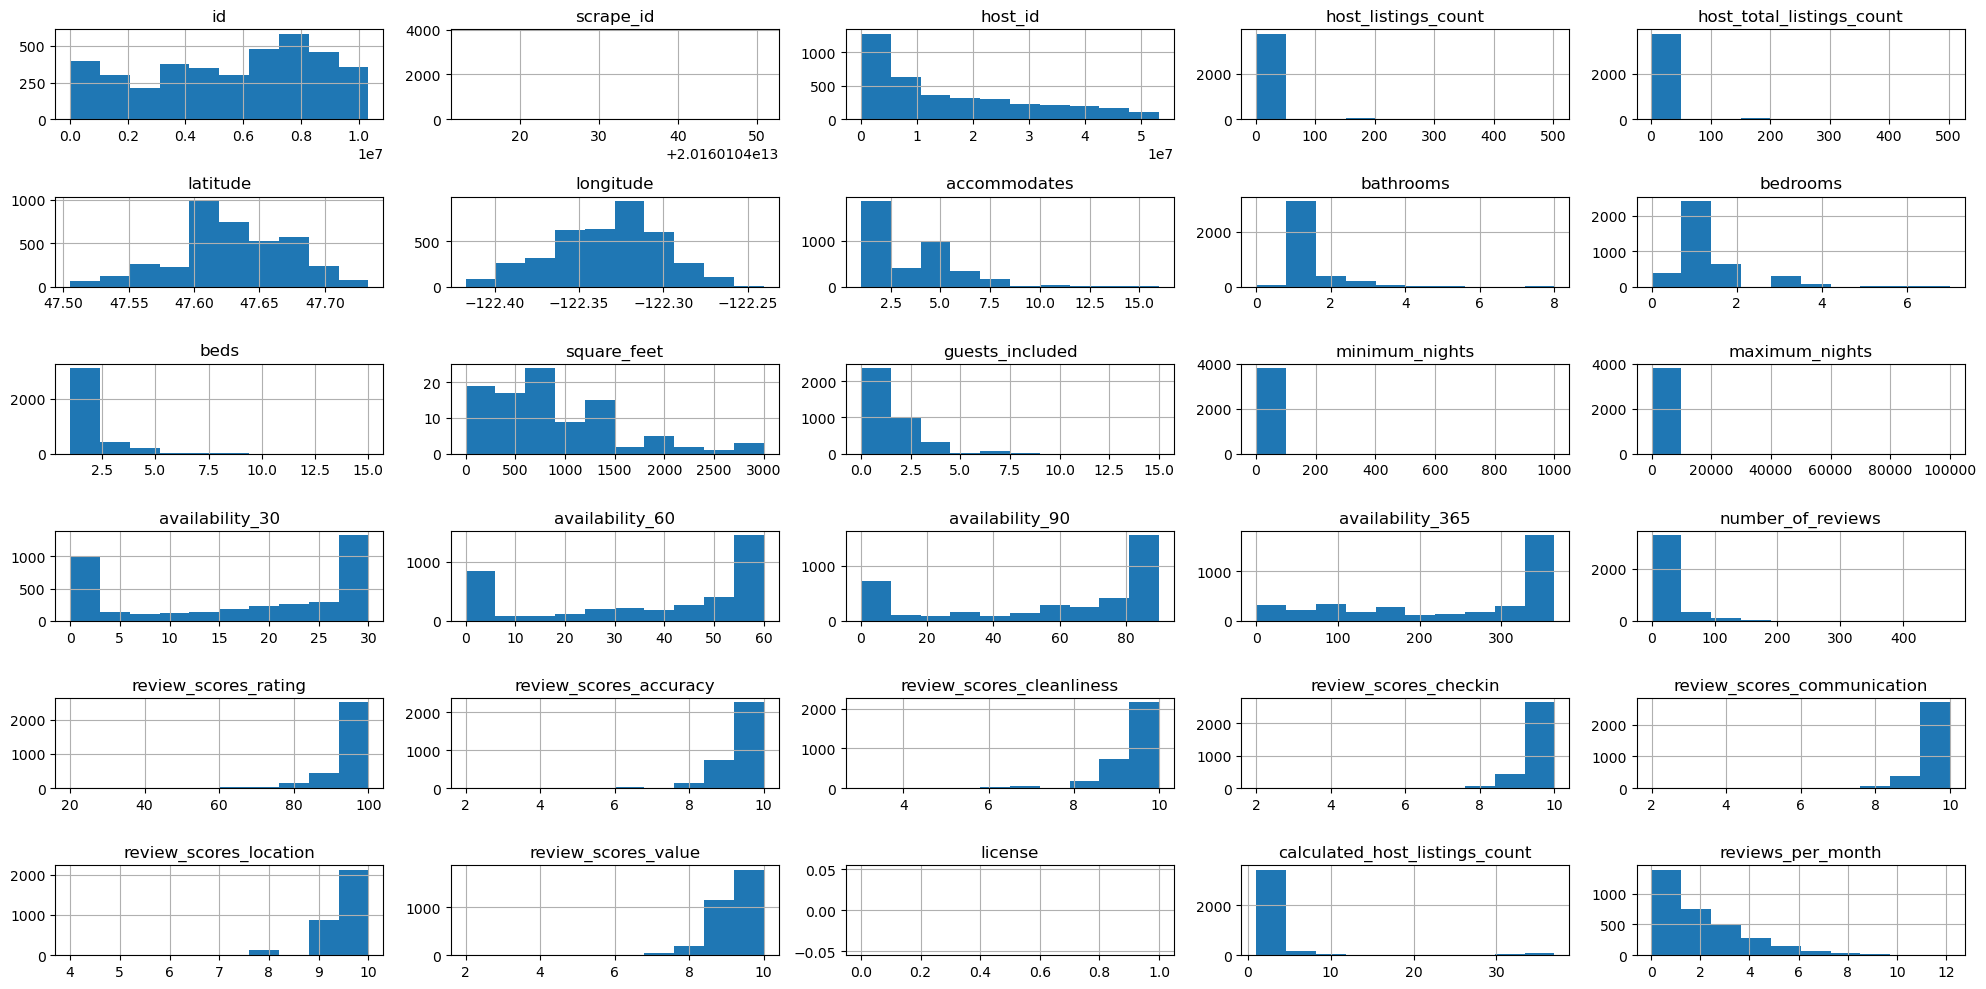





id|| mean: 5,550,111   median: 6,118,244   Not_NA: 3,818   NA: 0 proportion_NA: 0.0%

scrape_id|| mean: 20,160,104,002,432   median: 20,160,104,002,432   Not_NA: 3,818   NA: 0 proportion_NA: 0.0%

host_id|| mean: 15,785,555   median: 10,558,142   Not_NA: 3,818   NA: 0 proportion_NA: 0.0%

host_listings_count|| mean: 7   median: 1   Not_NA: 3,816   NA: 2 proportion_NA: 0.1%

host_total_listings_count|| mean: 7   median: 1   Not_NA: 3,816   NA: 2 proportion_NA: 0.1%

latitude|| mean: 48   median: 48   Not_NA: 3,818   NA: 0 proportion_NA: 0.0%

longitude|| mean: -122   median: -122   Not_NA: 3,818   NA: 0 proportion_NA: 0.0%

accommodates|| mean: 3   median: 3   Not_NA: 3,818   NA: 0 proportion_NA: 0.0%

bathrooms|| mean: 1   median: 1   Not_NA: 3,802   NA: 16 proportion_NA: 0.4%

bedrooms|| mean: 1   median: 1   Not_NA: 3,812   NA: 6 proportion_NA: 0.2%

beds|| mean: 2   median: 1   Not_NA: 3,817   NA: 1 proportion_NA: 0.0%

square_feet|| mean: 855   median: 750   Not_NA: 97   NA: 3,

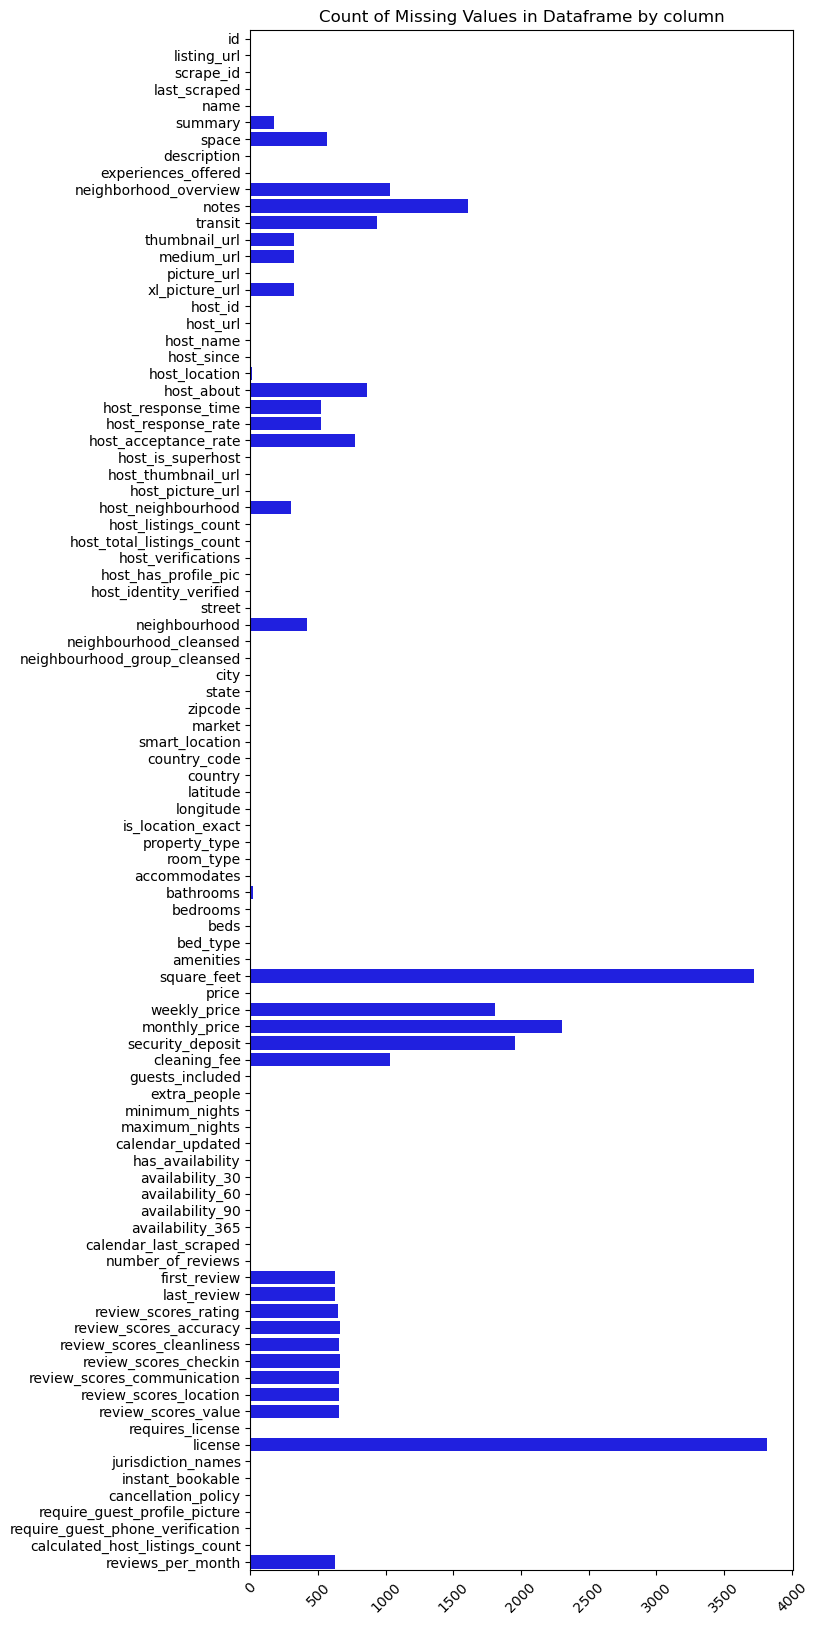

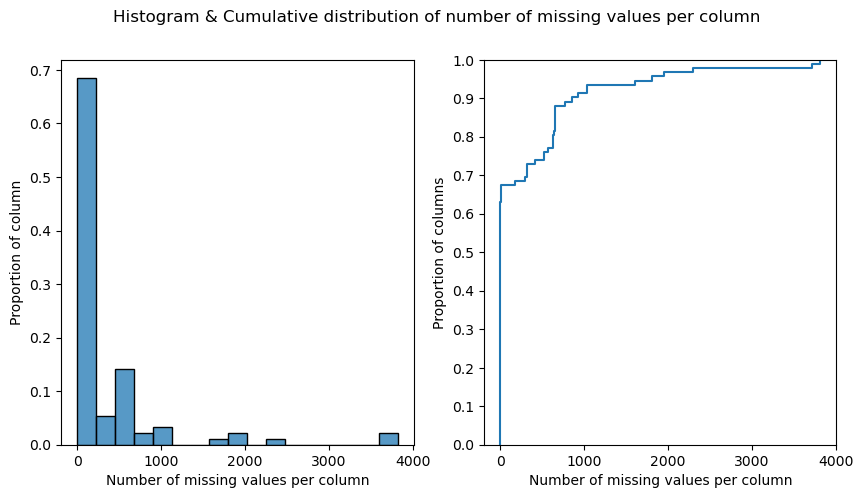

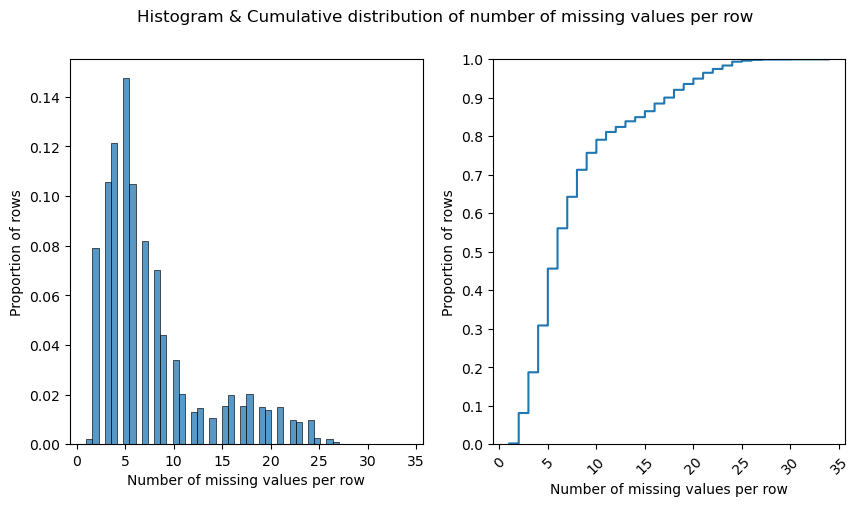





----------------------------------------------------------------------Head Information for calendar.csv----------------------------------------------------------------------


,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN






----------------------------------------------------------------------Basic Shape Information for calendar.csv----------------------------------------------------------------------
calendar.csv contains 1,393,570 rows and 4 columns.




The following columns only contain one value and can be dropped: 




These columns are numeric: listing_id




----------------------------------------------------------------------Basic statistics for calendar.csv----------------------------------------------------------------------


,listing_id
count,1.393570e+06
mean,5.550111e+06
std,2.962274e+06
min,3.335000e+03
25%,3.258213e+06
50%,6.118244e+06
75%,8.035212e+06
max,1.034016e+07






----------------------------------------------------------------------Histograme of numeric features calendar.csv----------------------------------------------------------------------


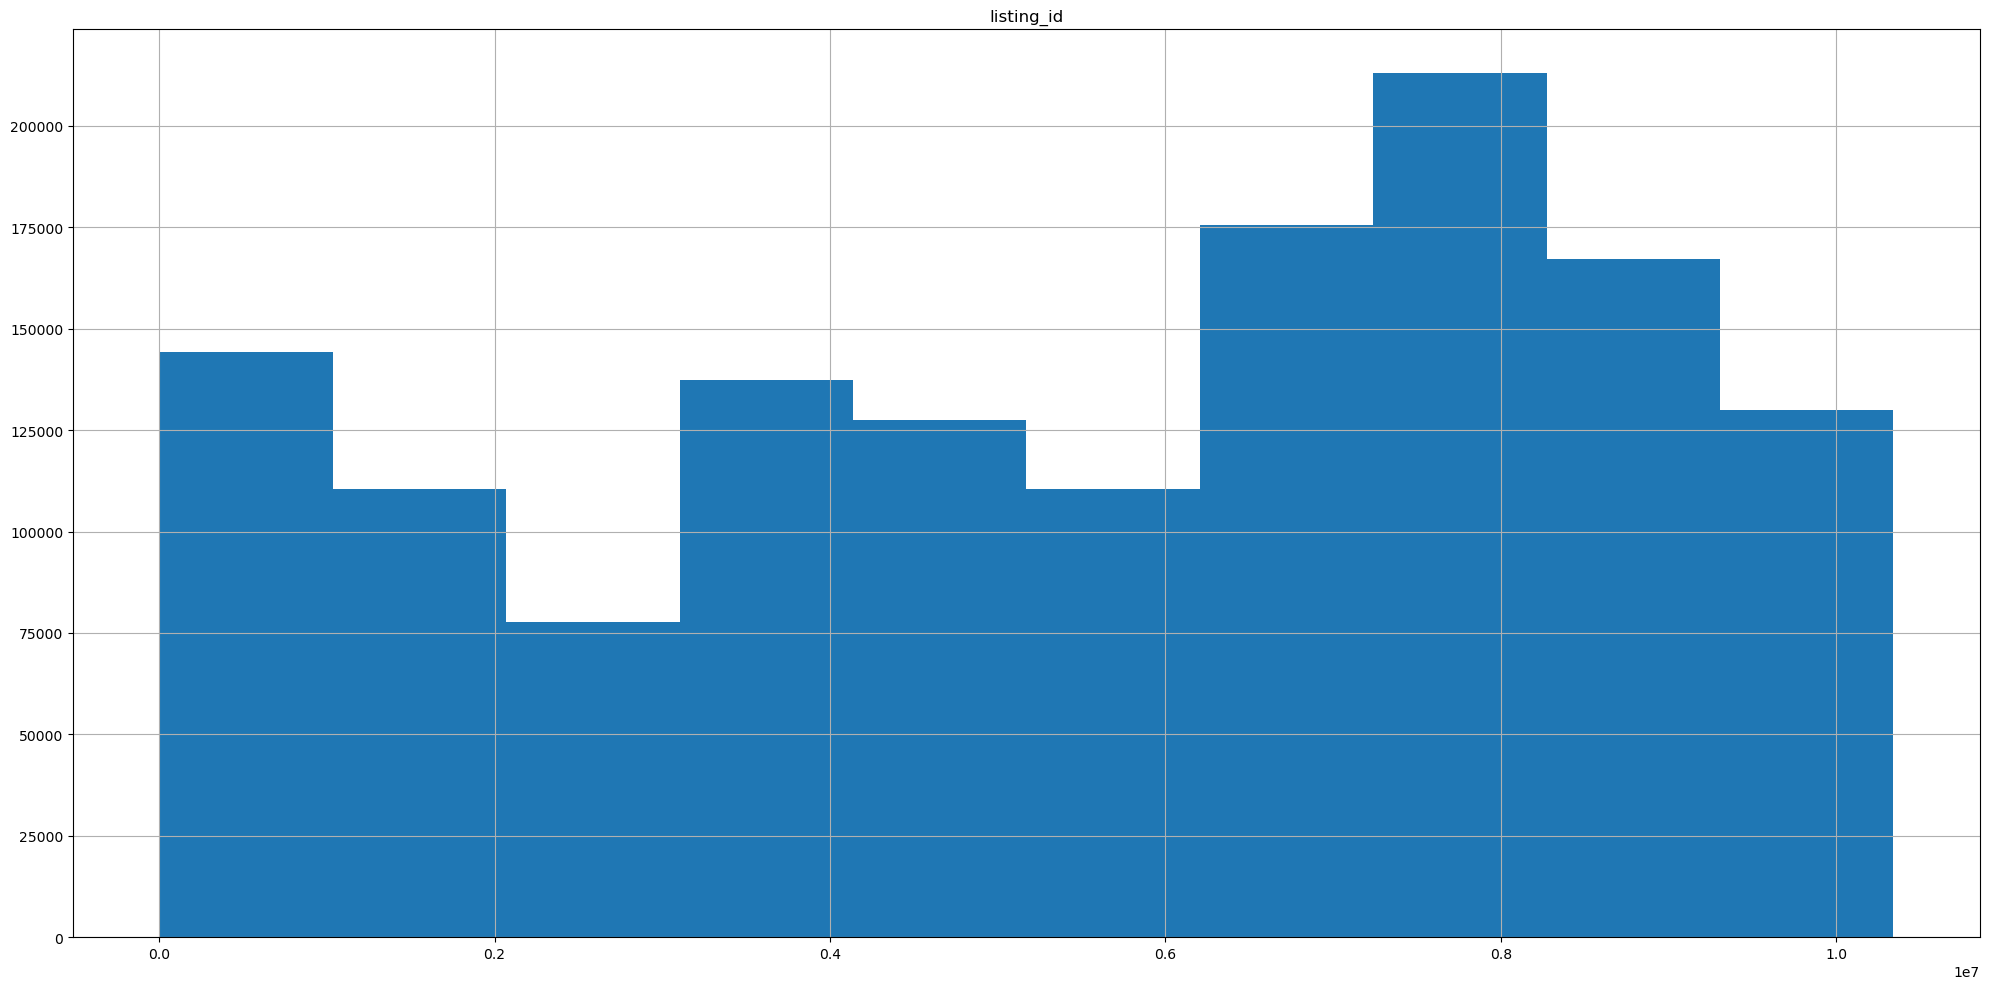





listing_id|| mean: 5,550,111   median: 6,118,244   Not_NA: 1,393,570   NA: 0 proportion_NA: 0.0%





These columns are non-numeric dtypes: date, available, price




----------------------------------------------------------------------First 5 top values with counts for each non-numeric feature calendar.csv----------------------------------------------------------------------
date: [('2016-01-04', 3818), ('2016-09-11', 3818), ('2016-09-09', 3818), ('2016-09-08', 3818), ('2016-09-07', 3818)]
num_unique: 365   not_NA: 1,393,570   NA: 0   proportion_NA: 0.0%

available: [('t', 934542), ('f', 459028)]
num_unique: 2   not_NA: 1,393,570   NA: 0   proportion_NA: 0.0%

price: [('$150.00', 36646), ('$100.00', 31755), ('$75.00', 29820), ('$125.00', 27538), ('$65.00', 26415)]
num_unique: 670   not_NA: 934,542   NA: 459,028   proportion_NA: 32.9%





----------------------------------------------------------------------More information about missing data for calendar.csv---------------------

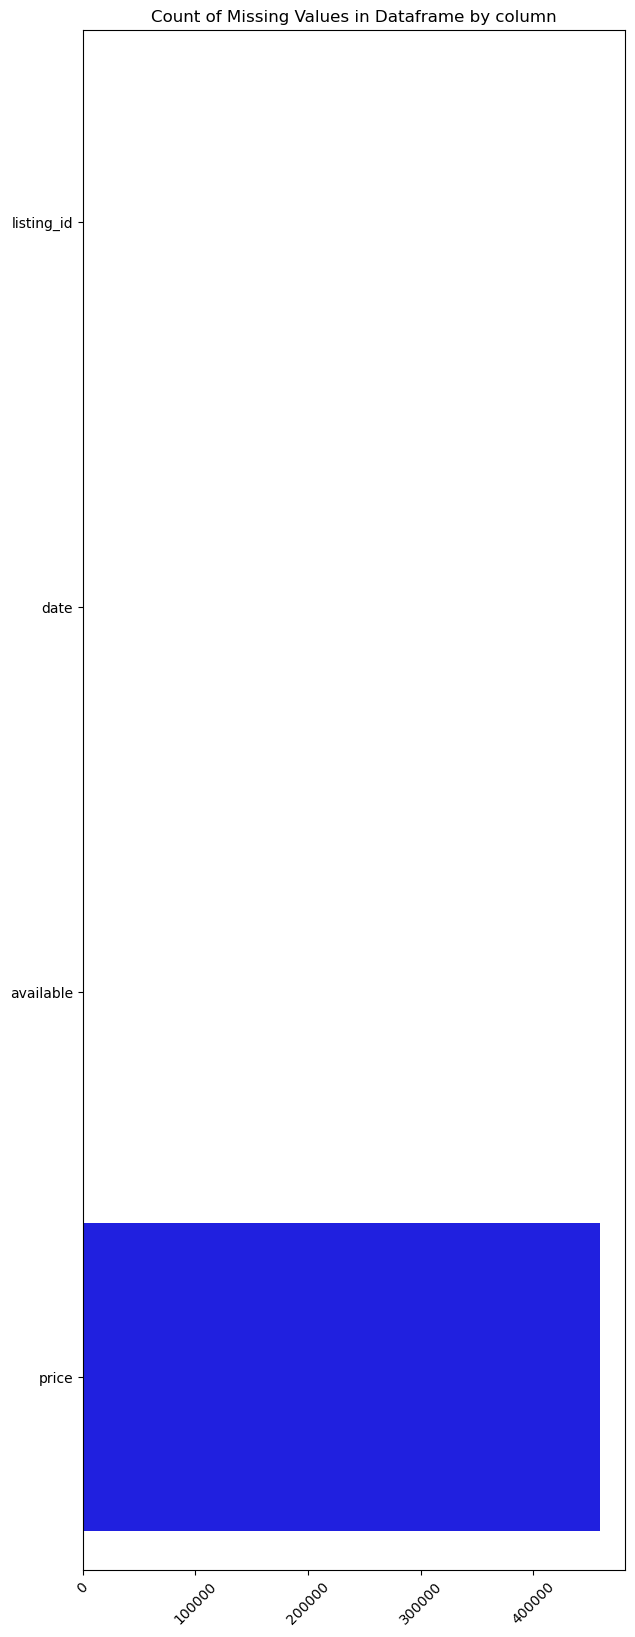

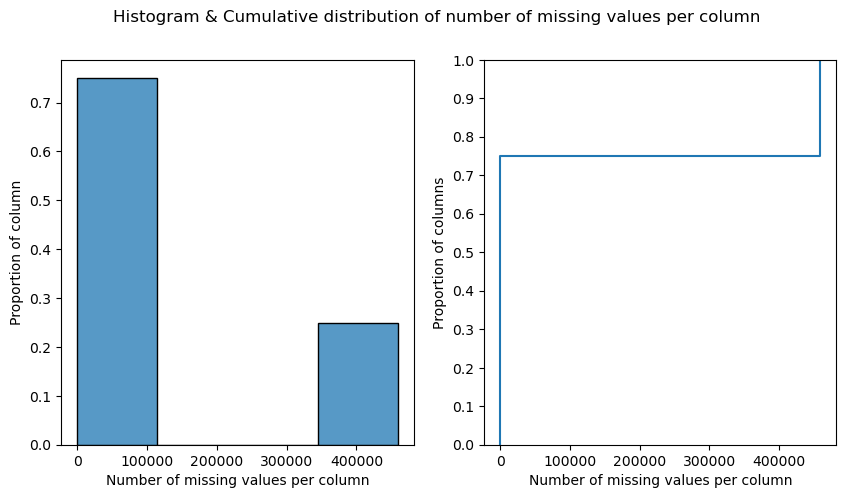

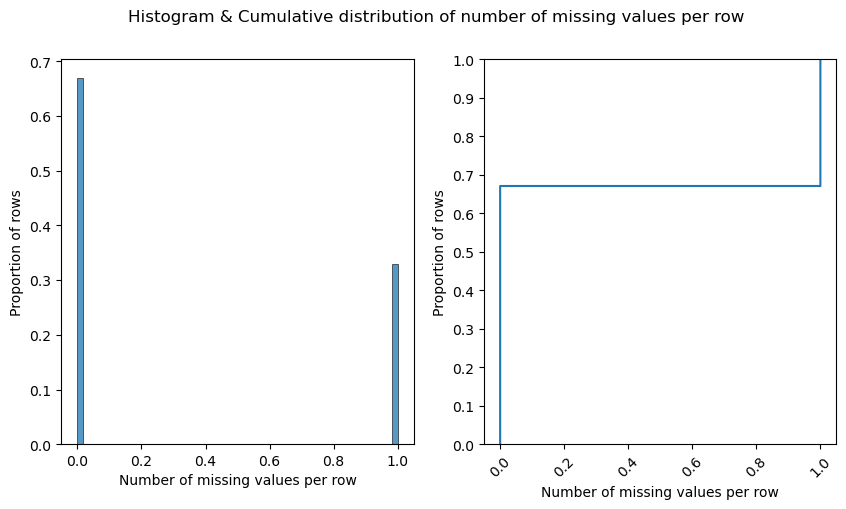





----------------------------------------------------------------------Head Information for reviews.csv----------------------------------------------------------------------


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...






----------------------------------------------------------------------Basic Shape Information for reviews.csv----------------------------------------------------------------------
reviews.csv contains 84,849 rows and 6 columns.




The following columns only contain one value and can be dropped: 




These columns are numeric: listing_id, id, reviewer_id




----------------------------------------------------------------------Basic statistics for reviews.csv----------------------------------------------------------------------


,listing_id,id,reviewer_id
count,8.484900e+04,8.484900e+04,8.484900e+04
mean,3.005067e+06,3.058765e+07,1.701301e+07
std,2.472877e+06,1.636613e+07,1.353704e+07
min,4.291000e+03,3.721000e+03,1.500000e+01
25%,7.946330e+05,1.725127e+07,5.053141e+06
50%,2.488228e+06,3.228809e+07,1.413476e+07
75%,4.694479e+06,4.457648e+07,2.762402e+07
max,1.024814e+07,5.873651e+07,5.281274e+07






----------------------------------------------------------------------Histograme of numeric features reviews.csv----------------------------------------------------------------------


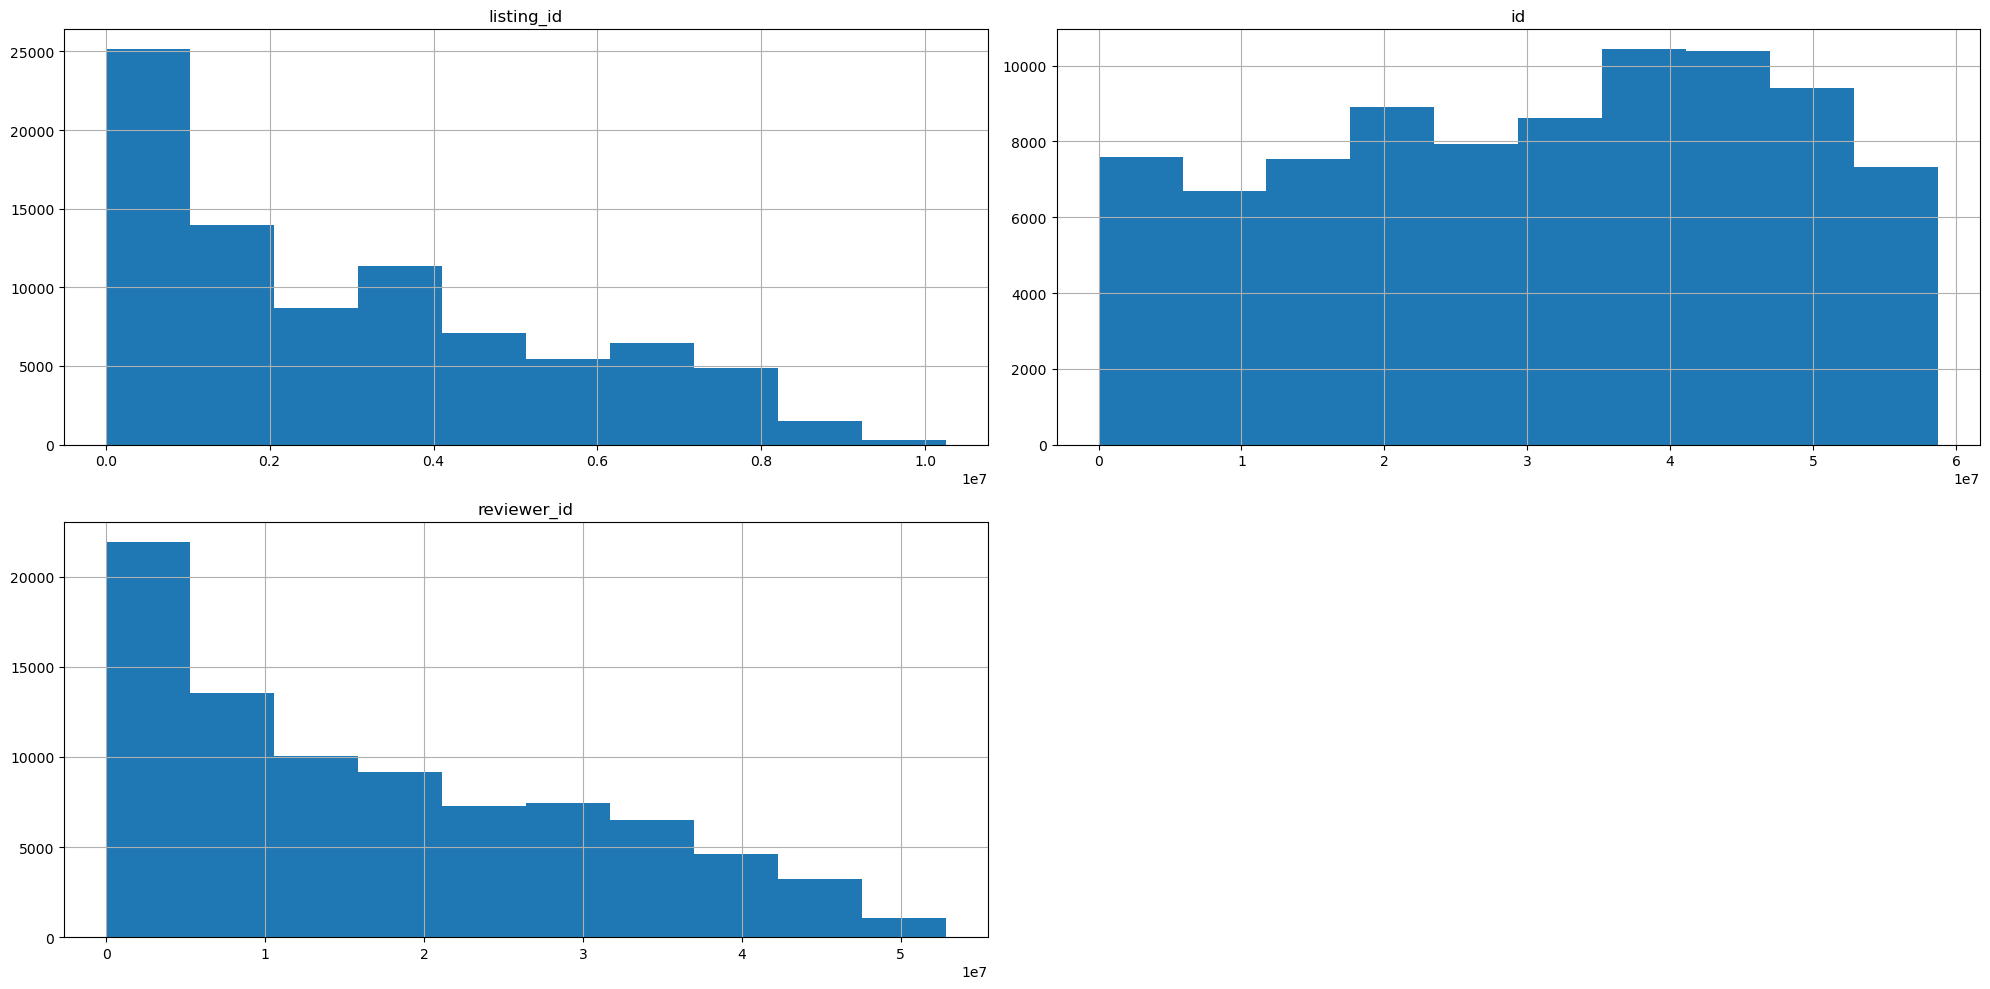





listing_id|| mean: 3,005,067   median: 2,488,228   Not_NA: 84,849   NA: 0 proportion_NA: 0.0%

id|| mean: 30,587,645   median: 32,288,093   Not_NA: 84,849   NA: 0 proportion_NA: 0.0%

reviewer_id|| mean: 17,013,007   median: 14,134,759   Not_NA: 84,849   NA: 0 proportion_NA: 0.0%





These columns are non-numeric dtypes: date, reviewer_name, comments




----------------------------------------------------------------------First 5 top values with counts for each non-numeric feature reviews.csv----------------------------------------------------------------------
date: [('2015-09-21', 580), ('2015-08-07', 400), ('2015-09-07', 384), ('2015-08-10', 383), ('2015-08-31', 371)]
num_unique: 1,930   not_NA: 84,849   NA: 0   proportion_NA: 0.0%

reviewer_name: [('David', 870), ('Michael', 822), ('Sarah', 681), ('John', 608), ('Chris', 570)]
num_unique: 14,380   not_NA: 84,849   NA: 0   proportion_NA: 0.0%

comments: [('The host canceled this re', 57), ('The reservation was cance', 48), ('T

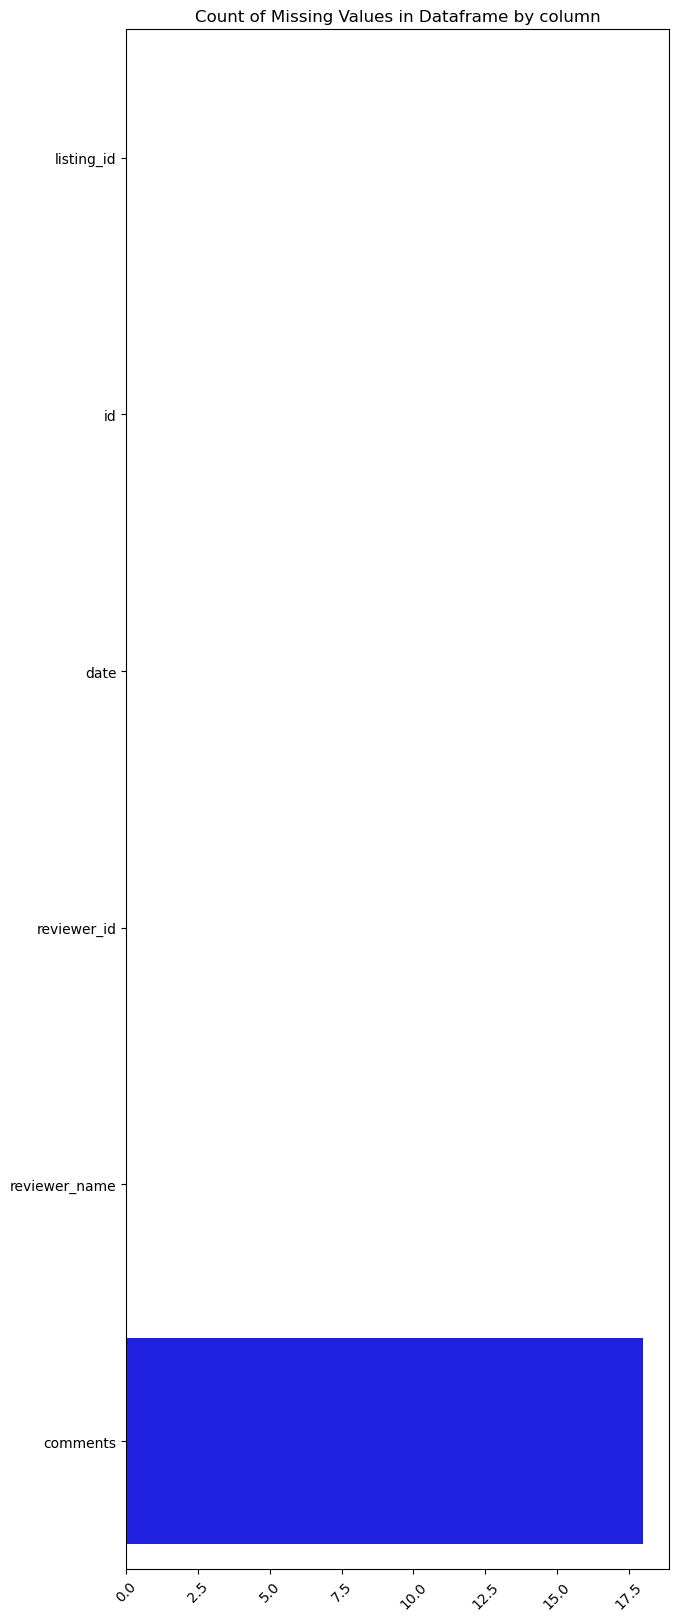

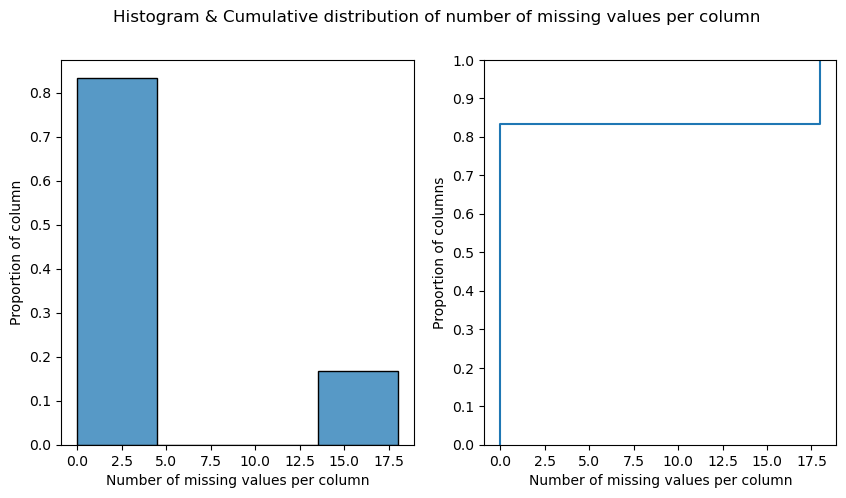

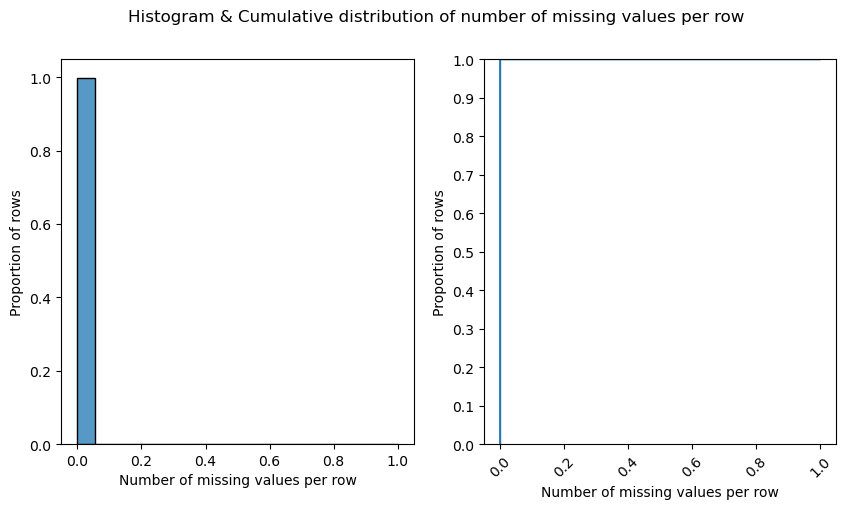

In [4]:
drop_columns_lst, numeric_cols_lst, non_numeric_cols_lst = describe_data(lst,"listings.csv")
drop_columns_cal, numeric_cols_cal, non_numeric_cols_cal = describe_data(cal,"calendar.csv")
drop_columns_rev, numeric_cols_rev, non_numeric_cols_rev = describe_data(rev,"reviews.csv")

## Cleaning the data
Now that that basic info can be seen for each dataframe, that information can be used to go through a few cleaning steps so that we can analyze the data.

### Columns that can be dropped
There are several columns with only 1 value in the listings dataframe, these can be removed, the other dataframes don't contain such columns.  'state' can also be dropped as the values are all 'WA' or 'wa' which are just both Washington.

In [5]:
lst.drop(columns=drop_columns_lst, inplace=True)
lst.drop(columns=['state'], inplace=True)

## Transforming columns to the correct datatype

There are several columns that are dates or numeric (like cost) but are labeled as object type.  These need to be updated to the correct datatypes.  There are also some numeric columns that should be objects (like the ID field)

In [6]:
# used for converting dollars to floats
def convert_dollars(x):
    return float(x.replace(',','').replace('$',''))

In [7]:
# For lst, transform to object - id, host_id
lst[['id','host_id']] = lst[['id','host_id']].astype('object')

# For lst, transform to number - host_response_rate, host_acceptance_rate, price, weekly_price, monthly_price, security_deposit, cleaning_fee, extra_people, 
lst['host_response_rate'] = lst['host_response_rate'].str.replace('%','').astype('float')/100
lst['host_acceptance_rate'] = lst['host_acceptance_rate'].str.replace('%','').astype('float')/100
lst[['price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people']] = lst[['price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people']].applymap(convert_dollars, na_action='ignore')

# For lst, transform to date - host_since,  first_review, last_review
lst[['host_since', 'first_review', 'last_review']] = lst[['host_since', 'first_review', 'last_review']].apply(pd.to_datetime)

# For lst, transform to bool - host_is_superhost, host_has_profile_pic, host_identity_verified, is_location_exact, instant_bookable, require_guest_profile_picture, require_guest_phone_verification
bool_cols = ['host_is_superhost','host_has_profile_pic','host_identity_verified','is_location_exact','instant_bookable','require_guest_profile_picture','require_guest_phone_verification']
lst[bool_cols] = lst[bool_cols].apply(lambda col: col.map({'t': True, 'f': False}))

In [8]:
# For cal, transform to object - listing_id
cal['listing_id'] = cal['listing_id'].astype('object')

# For cal, transform to number - price
cal[['price']] = cal[['price']].applymap(convert_dollars, na_action='ignore')

# For cal, transform to date - date
cal[['date']] = cal[['date']].apply(pd.to_datetime)

# For cal, transform to bool - available
cal[['available']] = cal[['available']].apply(lambda col: col.map({'t': True, 'f': False}))

In [9]:
# For rev, transform to object - listing_id, id, reviewer_id
rev[['listing_id', 'id', 'reviewer_id']] = rev[['listing_id', 'id', 'reviewer_id']].astype('object')

# For rev, transform to date - date
rev[['date']] = rev[['date']].apply(pd.to_datetime)


## Rename some fields that have the same name

So that it is more clear the column date will be updated so that it is clear which date is being referred to.

In [10]:
cal.rename(columns={'date': 'calendar_date'}, inplace=True)
rev.rename(columns={'date': 'review_date'}, inplace=True)

## Creating new variables

create new variable for sqft, break out the individual variables for columns such as amenities and host_verifications

The column square_feet is missing 97.5% of it's values.  Therefore it might be more useful to just track which listings have square feet instead of the square feet itself.

In [11]:
# assign 0 if sqft missing and 1 if it exists, also assign 0 if sqft is listed as <100 sqft (as there are a handful of units with implausible sqft)
def map_sqft(x):
    if pd.isna(x) or x < 100:
        return 0
    else:
        return 1

lst['square_feet_flag'] = lst['square_feet'].apply(map_sqft)

# drop the sqft column and use the newly mapped column instead
lst.drop(columns=['square_feet'], inplace=True)


In [12]:
# create a function to expand columns like amenities and host_verifications, returns a dataframe of counts
def count_values_list(df, column_name, replacement_regex):
    
    df[column_name] = df[column_name].str.replace(replacement_regex, '', regex=True)
    df[column_name] = df[column_name].str.split(',')    
    
    # where not na, create a temp df with a 1 if the value is in the list or 0 otherwise
    temp_df = df.loc[~df[column_name].isna(), column_name].apply(lambda x: pd.Series(1, index=x)).fillna(0, downcast='int')
    temp_df = temp_df.add_prefix(column_name+'_')
    temp_df_columns = list(temp_df.columns)
    
    # df[column_name].str.join('|').str.get_dummies()
    # https://saturncloud.io/blog/how-to-convert-a-column-of-list-to-dummies-in-pandas/#:~:text=Converting%20a%20column%20of%20lists%20into%20dummy%20variables%20is%20a,machine%20learning%20and%20statistical%20modeling.
    
    #below snippet could be used if we needed to count the occurences
    # Group by index and sum to get counts
    #count_df = dummy_df.groupby(level=0).sum()
    # Merge the count DataFrame back to the original
    #result_df = df.join(count_df)
    
    # join in the counts to the original df
    df = df.join(temp_df) 
    
    # if the origianl column value was nan then fill with a 0
    df[temp_df_columns] = df[temp_df_columns].fillna(0) 
     
    # drop the original column and drop the empty column name as this is the same as nothing being provided
    df.drop(columns=[column_name, column_name+'_'], inplace=True)
    
    return df

In [13]:
# create new variables for amenities and host_verifications
lst = count_values_list(lst, 'amenities', r'[{}"]')
lst = count_values_list(lst, 'host_verifications', r'[\[\'\] ]')

No long form text anlsysis will be used, so for some text columns that are probably important (such as description), use description length instead of the text description itself

In [14]:
# handle for description length, nans would be zero.
# summary, space, description, neighborhood_overview, notes, transit, host_about

long_text_cols = ['summary', 'space', 'description', 'neighborhood_overview', 'notes', 'transit', 'host_about']

text_len_df = pd.DataFrame()
for col in long_text_cols:
    text_len_df[col+'_len'] = lst[col].apply(lambda x: 0 if pd.isna(x) else len(x))
    
lst = lst.join(text_len_df)
lst.drop(columns=long_text_cols, inplace=True)

For links like thumbnail links or photo links, create new variables, 1 if exists or 0 otherwise, then drop the original columns

In [15]:
# transform link cols
link_cols = ['thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_url', 'host_thumbnail_url', 'host_picture_url']

# create a temp dataframe and return 0 if nan or 1 otherwise, then rejoin to original dataframe and drop the columns
bool_df = pd.DataFrame()
for col in link_cols:
    bool_df[col+'_bool'] = lst[col].apply(lambda x: 0 if pd.isna(x) else 1)
    
lst = lst.join(bool_df)
lst.drop(columns=link_cols, inplace=True)

In [16]:
# Now these columns only contain 1 value and can be dropped picture_url_bool, host_url_bool, host_thumbnail_url_bool, host_picture_url_bool
lst.drop(columns=['picture_url_bool', 'host_url_bool', 'host_thumbnail_url_bool', 'host_picture_url_bool'], inplace=True)

In [17]:
# for simplicity, parse the host_location into two categories, those specifically in Seattle and those outside of seattle or not specific enough to determine
# True = Host location is specified as Seattle
# False = Host Location was outside seattle, or not enough info was given, or value was NA

host_location_new = lst['host_location'].str.contains('seattle', case=False, regex=False, na=False)
lst = lst.join(host_location_new, rsuffix='_seattle_tf')
lst.drop(columns=['host_location'], inplace=True)

## Handling missing data

After creating some new variables there are still columns with missing data, these need to be handled.

### First handle numeric missing columns from the listings.  

The numeric columns that need handling are host_total_listings_count, host_listings_count, bathrooms, bedrooms, beds, host_response_rate, host_acceptance_rate, weekly_price, monthly_price, security_deposit, and cleaning.

The review scores and reviews_per_month will be handled seperately as part of the second business question.

host_listings_count and host_total_listings_count both are na for the same two rows, these two rows are also outliers regarding total number of missing values per row, so they are dropped

In [18]:
lst = lst.loc[~lst['host_listings_count'].isna()]

For some of the features missing data above, a function will be written to help fill values based on information in other columns

In [19]:
# write a function to fillna with most common value from anaother column

def fill_mode(df, col_to_fill, source_col):
    '''
    This function will look up in the source_col the most common (mode) response to values and use that to fill
    data in the col_to_fill.
    
    For example, if bathrooms (col_to_fill) is nan, use the most common number of bathrooms related to the guests_included (source_col)
    to estimate how many bathrooms there might be.  Fill the nan bathrooms with this number.  
    
    So if the most common number of bathrooms for 2 guests included is 1, then 1 will be used to fill the nan values for bathroom where guests inlcuded is 2
    
    df = dataframe to be updated
    col_to_fill = column with NA values that need to be filled with mode from other col
    source_col = use this column to determine the most common answer    
    '''
    # get a list from the column with nan values of counts based on the source_col
    mode_values_to_lookup = list(df.loc[df[col_to_fill].isna(), source_col].value_counts().index)
    
    for modes in mode_values_to_lookup:
        fill_value = df.loc[df[source_col] == modes, col_to_fill].mode()[0]
        df.loc[(df[col_to_fill].isna()) & (df[source_col] == modes), col_to_fill] = fill_value
        
# also write a function to fillna with the average from anaother column (to be used for filling review scores later in another business question)
def fill_avg(df_to_fill, source_df,col_to_fill, source_col):
    '''
    This function will look up in the source_col the average response to values and use that to fill
    data in the col_to_fill.
    
    For example, if review_score_accuracy (col_to_fill) is nan, use the average of review_score_accuracy related to that listing (source_col)
    to provide the most reasonable review_score_accuracy.  Fill the nan review_score_accuracy with this number.  
    
    So if the average review_score_accuracy for a listing is 8.5, then 8.5 will be used to fill the nan values for review_score_accuracy where the listing_id matches
    
    df_to_fill = dataframe to be updated
    source_df = dataframe to be used to get mean value
    col_to_fill = column with NA values that need to be filled with average from other col
    source_col = use this column to determine the average answer    
    '''
    # get a list from the column with nan values of counts based on the source_col
    avg_values_to_lookup = list(df_to_fill.loc[df_to_fill[col_to_fill].isna(), source_col].value_counts().index)
    
    for average in avg_values_to_lookup:
        fill_value = source_df.loc[source_df[source_col] == average, col_to_fill].mean()
        df_to_fill.loc[(df_to_fill[col_to_fill].isna()) & (df_to_fill[source_col] == average), col_to_fill] = fill_value

bathrooms, bedrooms, and beds will be estimated by the most common answer for those values from guests included.
For example, if the most common number of bathrooms for 2 guests included is 1, then 1 will be used to fill the nan values for bathroom where guests inlcuded is 2.

In [20]:
fill_mode(lst, 'bathrooms', 'guests_included')
fill_mode(lst, 'bedrooms', 'guests_included')
fill_mode(lst, 'beds', 'guests_included')

### Now handle some of the non-numeric columns from listings with missing data.

Those columns are  zipcode, host_neighbourhood, neighborhood, property_type

For the location, some of the columns seem duplicative and/or have missing info.  One column, neighbourhood_cleansed, has no missing values and according to the data dictionary has the meaning of:
 - "The neighbourhood as geocoded using the latitude and longitude against neighborhoods as defined by open or public digital shapefiles."
 - [source](https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit?pli=1#gid=1322284596)
 
It will be assumed that the lat/long info is correct and that the neighbourhood_cleansed would be the best feature to use for location.  Therefore the other location features could be dropped.

host_response_time, first_review, last_review will be handled in the second business question.

In [21]:
# Further evidence that neighbourhood and neighbourhood_cleansed mostly match is given by that most values are equivalent
match_percent = len(lst.loc[lst['neighbourhood']==lst['neighbourhood_cleansed']])/ len(lst)
print(f"The proportion of rows where neighbourhood and neighbourhood_cleansed match is {match_percent:.0%}")

The proportion of rows where neighbourhood and neighbourhood_cleansed match is 58%


Furthermore, host_neighbourhood isn't very useful as it matches neihborhood to large degree.  Since the host_location_cleaned feature was made earlier, host_neighbourhood is no longer needed

In [22]:
# Furthermore, host_neighbourhood isn't very useful as it matches neihborhood to large degree
match_percent = len(lst.loc[lst['neighbourhood']==lst['host_neighbourhood']])/ len(lst)
print(f"The proportion of rows where neighbourhood and host_neighbourhood match is {match_percent:.0%}")

# drop neighborhood location columns of neighbhourhood, zipcode, and host_neighbourhood
lst.drop(columns=['neighbourhood','zipcode','host_neighbourhood'], inplace = True)

The proportion of rows where neighbourhood and host_neighbourhood match is 81%


In [24]:
# There is 1 NA value for property_type, id of 3335 (index 2184).  Reading the description they call it a 2 apartment home.  So it will be assigned the property_type of Apartment
lst.loc[lst['property_type'].isna(), 'property_type'] = 'Apartment'

## Additional pre-cleaning of the data 

Remove some variables that aren't helpful such as listing url, host_name, smart_location, and city.  listing_url is not helpful since it is more or less an ID field with no inherent value. host_name is not usefull as we can link properties by host_id if needed. smart_location is basically multiple different ways to say Seattle, so it is not useful, same with city

In [25]:
lst.drop(columns=['listing_url', 'host_name', 'smart_location','city'], inplace=True)

## First Business Question
The data should be clean enough to now answer this question: What is the average review score by neighborhood?  Airbnb may want to know this so that they can promote neighborhoods that have higher reviews.

A few things to consider:
- We will focus on the overall rating of review_scores_rating.
- We don't have the review score for each review, just the average per listing, so to get the average by neighborhood we need to consider the number of reviews per listing so that we calculate the correct (weighted) average.
- We will only consider listings that actually have review scores.
- We will only look at neighborhoods that have at least 100 reviews

In [26]:
# create a df with only listings that have review scores.
lst_w_rvw = lst.loc[~lst['review_scores_rating'].isna()]

In [27]:
# get a dataframe with neighborhoods that have 100 or more reviews
more_than_100 = lst_w_rvw[['neighbourhood_cleansed','number_of_reviews']].groupby('neighbourhood_cleansed').sum()

# join in counts and then filter df to only neighborhoods that have more than 100 reviews
lst_w_rvw_more_100 = lst_w_rvw.join(more_than_100, on='neighbourhood_cleansed', rsuffix='_by_neighborhood')
lst_w_rvw_more_100 = lst_w_rvw_more_100.loc[lst_w_rvw_more_100['number_of_reviews_by_neighborhood'] >= 100]

In [28]:
# create a function to calculate the weighted average and then apply that function to each neighborhood
# source: https://stackoverflow.com/questions/69190358/weighted-average-by-another-column-in-pandas
wtd_avg = lambda x: sum(x['number_of_reviews'] * x['review_scores_rating']) / sum(x['number_of_reviews'])
neighborhood_avg_review = lst_w_rvw_more_100[['neighbourhood_cleansed','number_of_reviews','review_scores_rating']].groupby('neighbourhood_cleansed').apply(wtd_avg)
neighborhood_avg_review = neighborhood_avg_review.sort_values()

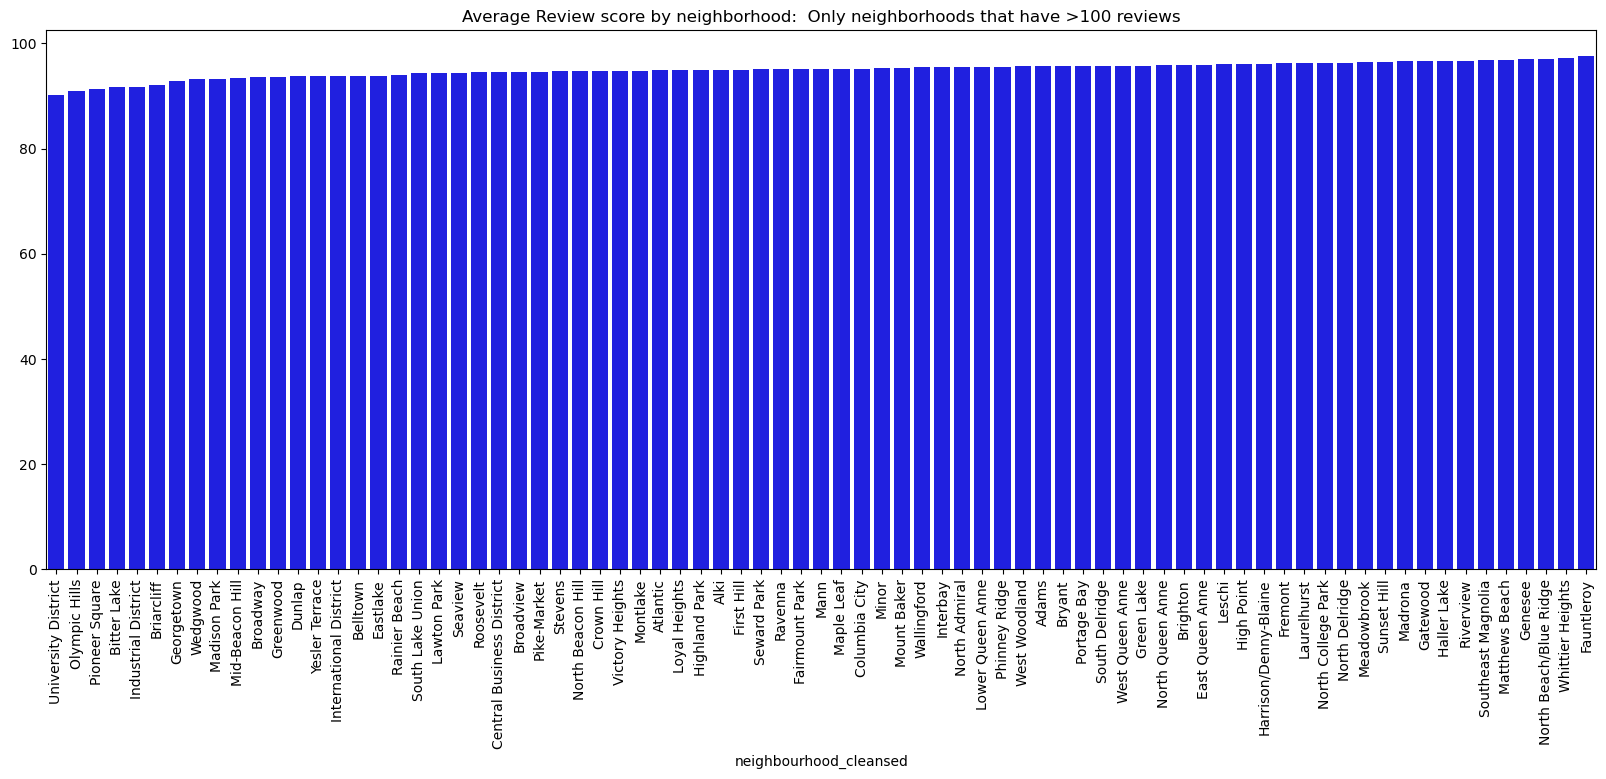

In [29]:
# Plot the data

plt.figure(figsize=(20,7))
sns.barplot(x=neighborhood_avg_review.index,
            y=neighborhood_avg_review.values,
            color='blue'
           );
plt.xticks(rotation=90);
plt.title('Average Review score by neighborhood:  Only neighborhoods that have >100 reviews');

## Second Business Question

Is it possible to determine which features are the most predictive when it comes to determining which Airbnbs are more popular (i.e. have the most stays).

The data does not have feature for number of stays, but it does have a feature for reviews per month.  It will be assumed that reviews per month can be thought of as an analogue to stays per month.  i.e. the more reviews a property has, it will be assumed also means the more stays that have occured at that location.  

A few things to consider here:
- There is a feature related to the availability of an Airbnb. However, the data does not discriminate between an Airbnb being unavailable due to the Owner not allowing a stay during that period vs the unit being unavailable do to it being rented for that period via Airbnb.  So this feature cannot be thought of as a way to answer the business question for how many stays the unit has.  
- The fact that the reviews are displayed as reviews per month is helpful as it provides a way to normalize between units that have been listed for many years vs just a short time.
- However, some units are fairly new and may have not been listed long enough to generate enough data or stable review per month avg.  Therefore only units that have been listed for at least 3 months at the time the data was collected will be used for the analysis.
    - It can be seen in the describe_data function that the data was scraped on 1/4/2016.  Therefore to determine if a unit has been listed at least 3 months, the first review date has to be at least on or occuring before 10/4/2015.
- Only listings where reviews_per_month have data will be considered



# get listings that have been listed for at least 3 months as of the data being scraped
# use dataframe rpm (reviews per month) for this analysis

In [30]:
rpm = lst.loc[~lst['reviews_per_month'].isna()]
rpm = rpm.loc[rpm['first_review'] <= '2015-10-04']

In [31]:
# examine which feature still contain nan values in rpm

rpm.columns[rpm.isna().any()].tolist()

['host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'weekly_price',
 'monthly_price',
 'security_deposit',
 'cleaning_fee',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value']

For rows that have null review_scores, fill them with the average for that neighborhood from lst.  For simplicity ignore taking a weighted average like we did for neighborhoods in the first business question.

In [32]:
fill_avg(rpm, lst,'review_scores_rating', 'neighbourhood_cleansed')
fill_avg(rpm, lst,'review_scores_accuracy', 'neighbourhood_cleansed')
fill_avg(rpm, lst,'review_scores_cleanliness', 'neighbourhood_cleansed')
fill_avg(rpm, lst,'review_scores_checkin', 'neighbourhood_cleansed')
fill_avg(rpm, lst,'review_scores_communication', 'neighbourhood_cleansed')
fill_avg(rpm, lst,'review_scores_value', 'neighbourhood_cleansed')
fill_avg(rpm, lst,'review_scores_location', 'neighbourhood_cleansed')

For host acceptance rate, this column appears possibly corrupted somehow, as nan might suggest that they never accept guests.  However, reading some of the reviews left by guests it's clear that people are staying there and having positive experiences, so this column will be dropped.

In [33]:
# join in comments to see what is being said about listings with nan acceptance rates
rpm.loc[rpm.host_acceptance_rate.isna()].join(rev.set_index('listing_id'), on='id',rsuffix='right')['comments'][0:10]

4    We had a great time staying here, very conveni...
4    Emily's home was beautfiul. It was so nice to ...
4    We very much enjoyed our stay at Emily and Dan...
4    This house was awesome! We were not planning o...
4    We loved Emily's beautiful, sunny home! And my...
4    Great house. A little tight but effective use ...
4    Emily's house is lovely!  Very quaint and a gr...
4    The reservation was canceled 118 days before a...
4    Thanks so much!\r\nThe house is beautiful and ...
4    Emily was fantastic! She kept her distance yet...
Name: comments, dtype: object

In [34]:
rpm.drop(columns=['host_acceptance_rate'], inplace=True)

For host response rate, nan values may mean that they have just never been messaged.  Therefore it will be assumed that they respond similar to the average listing if given the chance.  Since host response time is categorical, these values will be given the mode.

In [35]:
rpm['host_response_rate'].fillna(rpm['host_response_rate'].mean(), inplace=True)

In [36]:
rpm['host_response_time'].fillna(rpm['host_response_time'].value_counts().index[0], inplace=True)

For the security deposit and cleaning fee, assume missing values are missing b/c they don't charge for them, so fill 0

In [37]:
rpm[['security_deposit','cleaning_fee']] = rpm[['security_deposit','cleaning_fee']].fillna(0)

For weely and monthly prices, assume that nan values here mean that the unit is not available on a weekly or monthly basis.  For these values, create tracking features with 1 meaning that they are avaiable per week/month, and 0 to mean they are not.  Then fill those values with the daily rate * 7 for weekly and * 30.5 for monthly.

In [38]:
available_weekly = rpm['weekly_price'].notna().astype(int)
available_weekly.rename('available_weekly', inplace=True)
rpm = rpm.join(available_weekly)

# fill with daily rate x 7
rpm['weekly_price'].fillna(rpm['price'] * 7, inplace=True)

In [39]:
available_monthly = rpm['monthly_price'].notna().astype(int)
available_monthly.rename('available_monthly', inplace=True)
rpm = rpm.join(available_monthly)

# fill with daily rate x 30.5
rpm['monthly_price'].fillna(rpm['price'] * 30.5, inplace=True)

There are a few columns that won't be considered when making a prediciton.
- latitude and longitude, will use neighbourd_cleansed for location
- id, this is just a unique listing ID and is not useful for predicting
- street, for simplicity and reducing the number of columns created with onehot encoding.  Also neighbourhood cleansed will be used as a proxy for location
- name, for simplicity name will not be considered
- host_id, this is similar to id and the number of listings is already known via the host_listing_count feature
- host_total_listings count is a duplicate of host_listings_count, so it can be dropped
- first_review, last_review and number_of_reviews won't be used as these could be used to directly caculatin the reviews per month. 

The categories to be encoded are
- host_response_time, neighbourhood_cleansed, neighbourhood_group_cleansed, property_type,  room_type, bed_type, calendar_updated, cancellation_policy, 

Date values need special handling. 
- host_since, Because data was scraped on 1/4/2016, host_since will be converted to # of days being a host through 1/4/2016.

In [40]:
#drop the unneeded columns
rpm.drop(columns=['latitude','longitude','id','street','name', 'host_id', 'host_total_listings_count','number_of_reviews'], inplace=True)

In [41]:
# calculate the number of days a host has been active on airbnb
rpm['total_days_host'] = (pd.to_datetime('2016-01-04') - rpm['host_since']).dt.days

# calculate the number of days between the first and last review
#rpm['rpm['last_review'] - rpm['first_review']).dt.days

rpm.drop(columns=['host_since','first_review', 'last_review'], inplace=True)

### Begin to prep the data with scikit learn

In [42]:
# convert the true/false columns to 1's and 0's
bool_cols = ['is_location_exact','instant_bookable','require_guest_profile_picture','require_guest_phone_verification','host_location_seattle_tf','host_is_superhost', 'host_has_profile_pic', 'host_identity_verified']
rpm[bool_cols] = rpm[bool_cols].astype(int)

In [43]:
# create a new dataframe for the Y variable and drop it from the X dataframe
reviews_per_month = rpm[['reviews_per_month']]
rpm.drop(columns=['reviews_per_month'], inplace=True)

Since we have mixed data types we can build a series of sklearn preprocessors to help one-hot encode the data.
- [Source](https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html)

In [44]:
#from sklearn.feature_selection import f_regression
# build out the transformations for the columns
categorical_features = ['host_response_time', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'property_type', 'room_type', 'bed_type', 'calendar_updated', 'cancellation_policy']
categorical_transformer = Pipeline(
    steps=[
           ('encoder', OneHotEncoder(handle_unknown='ignore')),
         #  ("selector", SelectPercentile(f_regression, percentile=50))
          ]
           
)

numeric_features = ['calculated_host_listings_count', 'host_response_rate', 'host_listings_count', 'accommodates', 'bathrooms', 'bedrooms', 'beds', \
                    'price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'guests_included', \
                    'extra_people', 'minimum_nights', 'maximum_nights', 'availability_30', \
                    'availability_60', 'availability_90', 'availability_365', 'review_scores_rating', \
                    'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', \
                    'review_scores_location', 'review_scores_value', 'summary_len', 'space_len', 'description_len', \
                    'neighborhood_overview_len', 'notes_len', 'transit_len', 'host_about_len', 'total_days_host']
numeric_transformer = Pipeline(
    steps = [('scaler', StandardScaler())]
)


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ],
    remainder='passthrough' # passthrough the bool columns untouched
)



In [45]:
# build the classifier pipeline
clf = Pipeline(
    steps=[('preprocessor', preprocessor), ('classifier', RandomForestRegressor(random_state=41))]
)

# Split the data into training and tesing sets
X_train, X_test, y_train, y_test = train_test_split(rpm, reviews_per_month, test_size = 0.30, random_state=41)

clf.fit(X_train, y_train.to_numpy().flatten())
#calculate the R2_score
print(clf.score(X_test, y_test))

#above equivalent to
#pred = clf.predict(X_test)
#print(r2_score(y_test, pred))

0.527653922875074


Chart the top features by feature importance

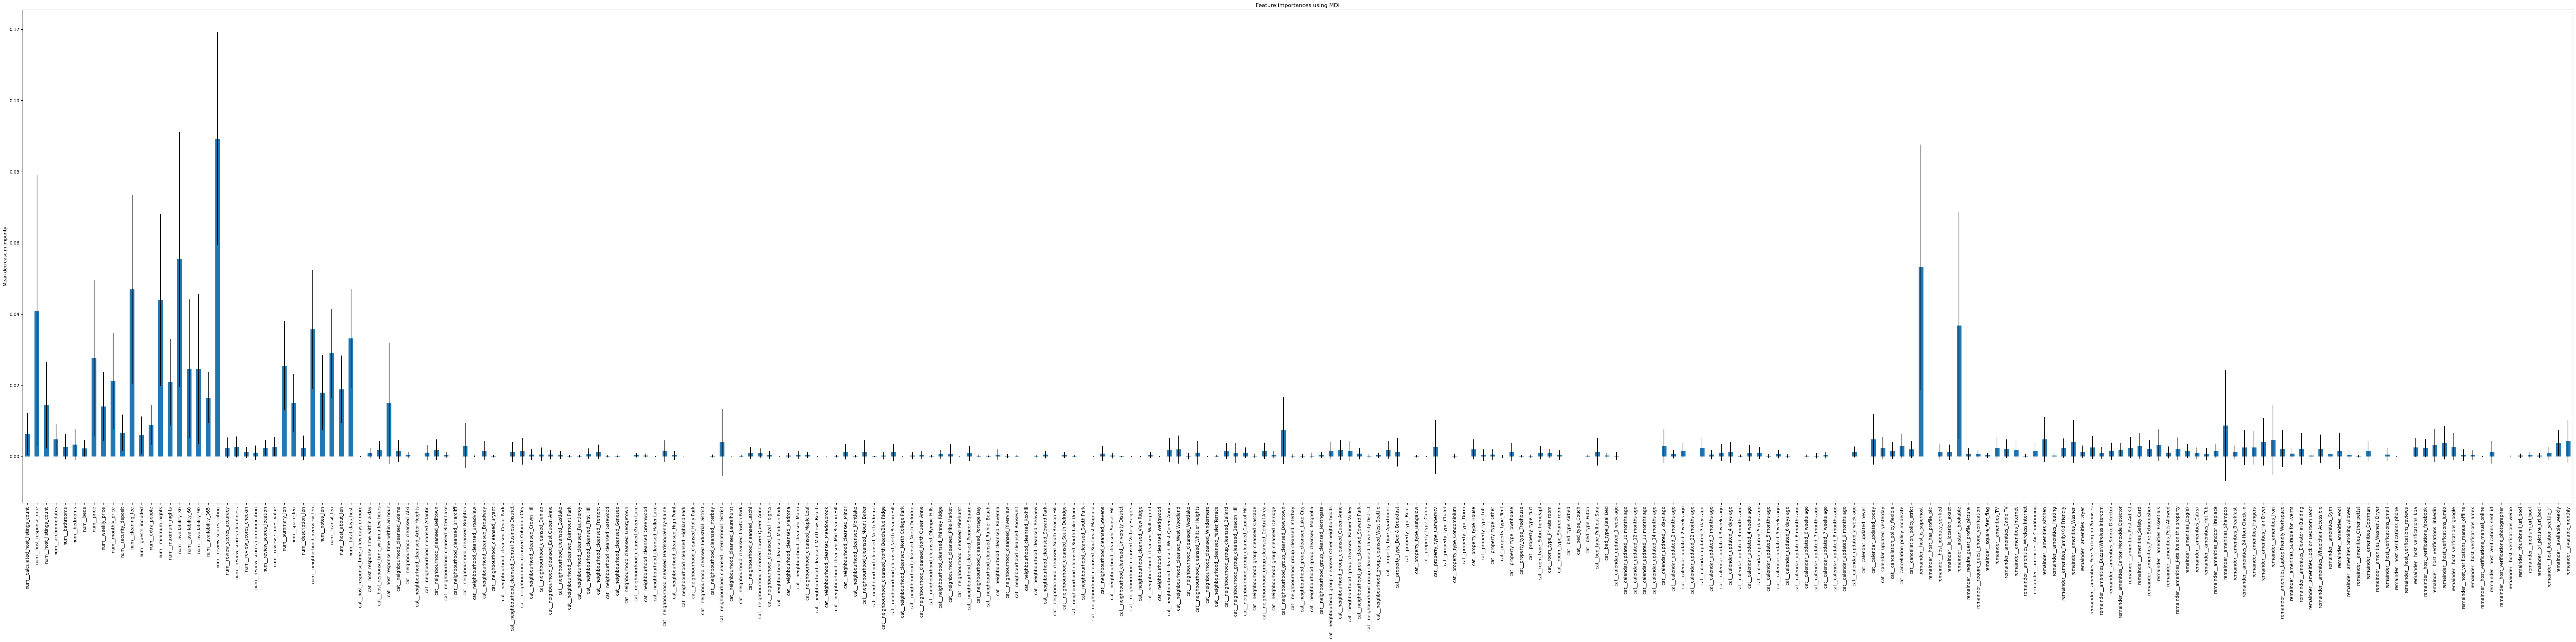

In [46]:
# source https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
importances = clf[-1].feature_importances_
std = np.std([tree.feature_importances_ for tree in clf[-1].estimators_], axis=0)

forest_importances = pd.Series(importances, index=clf[:-1].get_feature_names_out())

fig, ax = plt.subplots(figsize=(80,20))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

It can be seen that the most important features are...

...
..


## Third Business Question

What months are the year are most popular for visiting Seattle?

This might be useful for Airbnb to see so that they can target advertising to see if they can create more demand for times of year that are less popular to visit Seattle.

A few things to consider here:
- Similar to the second question, number of reviews will be used as an analogue to number of stays.
- The reviews.csv will be used to answer this question
- It will be assumed that the month of the review correlates to the month of the stay
-  From the describe data function it is known that there are only 18 comments missing and no other nan vales.  Those rows can still be used since the only metric of interest is the review_date

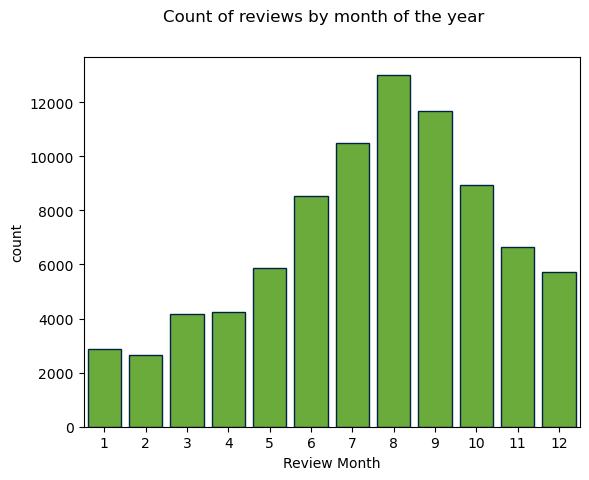

In [47]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
fig, ax = plt.subplots()
sns.countplot(x=rev['review_date'].dt.month,
              color='#69BE28',
              edgecolor='#002244'
             );
fig.suptitle('Count of reviews by month of the year');
ax.set_xlabel('Review Month');

